## A/B Testing the Landing Page for a Website

>by Reema Mohsin


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

Using the data provided in *ab_data.csv*, I will run multiple tests to evaluate whether an e-commerce company should launch a new landing page on their website in order to increase conversion rates of users.

I will perform three different tests:
* a hypothesis test using simulated samples of the given data
* a z-test
* a logistic regression model


<a id='probability'></a>
#### Part I - Probability

To get started, I have imported all the libraries I will need to complete this project.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Next, I read in the dataset and explore its features.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [19]:
#transform timestamp column from string to datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [21]:
#calculate experiment duration
df['timestamp'].max() - df['timestamp'].min()

Timedelta('21 days 23:59:49.081927')

In [60]:
#number of unique users in the dataset
df['user_id'].nunique()

290584

In [61]:
#the proportion of users that converted
df['converted'].mean()

0.11965919355605512

Next, I will check to see if there is any inaccurate or missing data in the table. Inaccurate data includes rows where the user's *group* and *page* don't match. 

The **control** group should have the **old page**.
The **treatment** group should have the **new page**

In [4]:
#find all rows where the group and page don't match as they're supposed to
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group == "control" and landing_page == "new_page"').shape[0]

3893

In [20]:
#check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


Because there are 3893 instances of rows with mismatched group and page data. I will create a new dataframe containing only accurate rows. Since there are no null values, there is no problem of missing data.

In [6]:
#create a new table with only rows with matching data
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')

In [7]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [8]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

Now, I will check for any duplicated data. To do this, I will first see how many unique users exist in the table.

In [9]:
#number of unique users
df2['user_id'].nunique()

290584

In [10]:
#number of rows in total
df2.shape[0]

290585

There appears to be a repeated user in the dataset. The code below will identify which one.

In [68]:
pd.concat(x for _, x in df2.groupby("user_id") if len(x) > 1)

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Because the information in both rows is the same, I can remove one of these rows to avoid duplication of data.

In [11]:
#drop one duplicated row
df2 = df2.drop_duplicates('user_id')

Before I begin testing the data, I would like to do preliminary calculations to understand the probabilities of conversion by group.

In [70]:
#proportion of users that converted regardless of group
df2['converted'].mean()

0.11959708724499628

In [71]:
#proportion of users in the control group that converted
df2[df2['group']=="control"]['converted'].mean()

0.1203863045004612

In [72]:
#proportion of users in the treatment group that converted
df2[df2['group']=="treatment"]['converted'].mean()

0.11880806551510564

In [73]:
#probability of a user receiving the new landing page
df2[df2['landing_page']=="new_page"].shape[0]/df2.shape[0]

0.5000619442226688

Based on the probabilities calculated above, there is not sufficient evidence to conclude that the new treatment page leads to more conversions, or that either page performs better than the other. The difference in probabilities needs to be tested for statistical significance. 

<a id='ab_test'></a>
### Part II - A/B Test

In this part, I will run a hypothesis test using bootstrap sampling and compare that with the results from the built in *z-test* function available in the stats package I have imported. 

Below I have stated my null and alternative hypotheses. $p_{old}$ refers to the probability of conversion from the old landing page and $p_{new}$ refers to the probability of conversion from the new landing page. As you can see, I am performing a one-tailed hypothesis test.

$$H_0: p_{old} \geq p_{new} $$
$$H_1: p_{old} < p_{new} $$

I will begin the following calculations under assumption of the null hypothesis. Therefore, I will assume that $p_{new} = p_{old}$. 

In [74]:
#the conversion rate regardless of group
df2['converted'].mean()

0.11959708724499628

Now, I calculate $n_{new}$, the number of individuals in the treatment group.

In [26]:
df2[df2['group']=="treatment"].shape[0]

145310

Then $n_{old}$, the number of individuals in the control group.

In [27]:
df2[df2['group']=="control"].shape[0]

145274

Now that I have $n_{new}$ and $n_{old}$, I can perform 10,000 simulated bootstrap samples of population size to get an array of 10,000 differences in proportions of control group conversions and treatment group conversions.

In [14]:
#array to hold all differences
p_diffs = []

#loop to create samples
for _ in range(10000):
    new_df = df2['converted'].sample(145310,replace=True)
    old_df = df2['converted'].sample(145274,replace=True)
    p_diffs.append(new_df.mean() - old_df.mean()) #calculate differences and add to array

p_diffs = np.array(p_diffs) #convert Series to array

Below, I have plotted a histogram of the results from the sample. As expected, the results are normally distributed around the intended center value of 0.

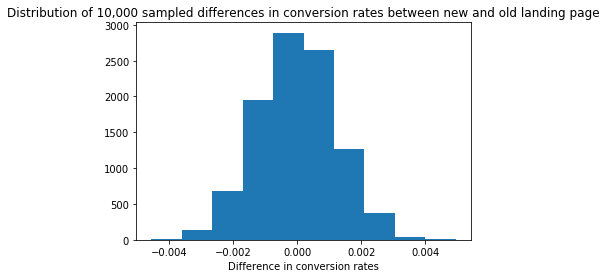

In [77]:
plt.hist(p_diffs);
plt.title('Distribution of 10,000 sampled differences in conversion rates between new and old landing page');
plt.xlabel('Difference in conversion rates');

I will now calculate the actual observed difference.

In [12]:
obs_diff = df2[df2['group']=="treatment"]['converted'].mean() - df2[df2['group']=="control"]['converted'].mean()
obs_diff

-0.0015782389853555567

In [15]:
pval = (p_diffs > obs_diff).mean()
pval

0.90659999999999996

The above calculated value is called the p-value. This value indicates the probability of obtaining a value greater than the observed statistic under the assumption of the null hypothesis. Because this value is high and much greater than the Type 1 error rate of 5%, we fail to reject the null hypothesis. 

Now I will use a built-in z-test function to calculate the same value and compare my results.

In [81]:
#import library
import statsmodels.api as sm

#prepare data points
convert_old = df2[df2['group']=="control"]['converted'].sum()
convert_new = df2[df2['group']=="treatment"]['converted'].sum()
n_old = df2[df2['group']=="control"].shape[0]
n_new = df2[df2['group']=="treatment"].shape[0]

In [83]:
z,p = sm.stats.proportions_ztest([convert_old, convert_new],[n_old,n_new], alternative='smaller')
print("Z value: ",z)
print("p value: ",p)

Z value:  1.31092419842
p value:  0.905058312759


The p-value above is very close to the p-value I calculated earlier, which means my hypothesis test result was accurate. 

<a id='regression'></a>
### Part III - A regression approach

In this part, I will attempt to achieve the same results from above using regression analysis. Since each row represents conversion or no conversion, I will be performing a logistic regression to understand this categorical data. My null and alternative hypotheses are given below.

$H_0:$ Coefficient of ab_page = 0  
$H_1:$ Coefficient of ab_page $\neq$ 0 

Since the group that each user belongs to is also categorical information, I will need to create dummy variables.

In [33]:
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


I then use **statsmodels** to instantiate my regression model on the two columns I just created. Then I fit the model to predict whether or not an individual converts. 

In [36]:
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


The summary of the model is below.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 20 Sep 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:35:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associate with ab_page from the logistic regression model is about 2 times the p-value calculated in Part II. This is because in the logistic regression model I am performing a two tailed test rather than a one-tailed test.

In [16]:
np.exp(-0.0150)

0.98511193960306265

The above number can be interpreted as "a user from the treatment group is 0.985 times less likely than someone from the control group to convert." This doesn't seem to be a practically significant figure, which leads me to a conclusion that the landing page of the company's website is not a very good predictor of conversion of a user. 

I will now be adding the data from *countries.csv* to see how the country a user lives in influences their conversion likelihood. It is a good idea to understand what factors can be used to predict the outcome of a test, however, some terms may make the model unreliable due to effects such as correlated errors or outliers, etc. 

In [47]:
df_c = pd.read_csv('countries.csv')
df2 = df2.join(df_c.set_index('user_id'),on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


I first loaded the data into a dataframe, then joined it with my original table on user ids. Next, I will create more dummy variables because country is considered a categorical variable.

In [49]:
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])

Now I will run the model including the new variable.

In [52]:
log_mod2 = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 20 Sep 2019   Pseudo R-squ.:               2.323e-05
Time:                        21:18:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [56]:
np.exp(0.0408), np.exp(.0099), np.exp(-0.0149)

(1.0416437559600236, 1.0099491671175422, 0.9852104557227469)

When adding the additional variable of country, the model indicates that a user's country does not have significant impact on their likelihood to convert. As before, the coefficients derived from this model do not indicate any practical or statistical significance of a variable's effect on predicting conversion. 

Lastly, I would like to run the model using the interaction of the country variable and the page variable to see if the effect of a user's group changes depending on their country as well. I create new variables to test this.

In [57]:
df2['CA_page'] = df2['CA']*df2['ab_page']
df2['UK_page'] = df2['UK']*df2['ab_page']
df2['US_page'] = df2['US']*df2['ab_page']

In [58]:
log_mod3 = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK','CA_page','UK_page','US_page']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 20 Sep 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:44:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0193   3.15e+05  -6.13e-08      1.000   -6.17e+05    6.17e+05
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0482   3.15e+05  -1.53e-07      1.000   -6.17e+05    6.17e+05
UK_page        0.0301   3.15e+05   9.57e-08      1.000   -6.17e+05    6.17e+05
US_page       -0.0013   3.15e+05  -4.03e-09      1.000   -6.17e+05    6.17e+05
==============================================================================
"""

In [59]:
np.exp(results3.params)

intercept    0.137178
ab_page      0.980891
CA           0.982625
UK           0.994272
CA_page      0.952987
UK_page      1.030587
US_page      0.998731
dtype: float64

Even when looking at the interaction between group and country, the model indicates that there is very little statistical impact of these variables on the likelihood of a user to convert. 

<a id='conclusions'></a>
## Conclusions

I took many different approaches to A/B test the company's new landing page. All test results led me to conclude that the probability of someone from the new landing page converting is neither statistically nor practically significant in difference from the probability of someone from the old landing page converting.

My final recommendation is to use either landing page, since they produce similar results in terms of conversion. I do not suggest running the experiment for a longer time since change aversion does not appear to be an issue with these users. Since, in the 21 days of the experiment, only one user had a repeat visit to the website, it does not seem likely that an existing user's preference for an old landing page and aversion to change has an actual effect on their user experience. 

In [22]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0